##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install pandas 
#%pip install numpy
#%pip install matplotlib
#%pip install sckit-learn
#%pip install seaborn
#%pip install datetime
#%pip install mlxtend
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from datetime import date
import mlxtend
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file
pd.options.display.max_rows = 10000

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## Data Cleaning / EDA

In [2]:
train_df = pd.read_parquet(filepath)
print(train_df.shape)

(17992, 304)


In [3]:
train_df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


- remove None/NaN
- change min_occ_date and cltdob_fix format
- categorical variable to do one-hot encoding: race_desc, ctrycode_desc, clttype 

In [4]:
print(train_df['race_desc'].value_counts())
print(train_df['clttype'].value_counts())
print(train_df['stat_flag'].value_counts())

Chinese    10520
Others      1699
Malay        928
Indian       849
Name: race_desc, dtype: int64
P    14657
G     3311
C       24
Name: clttype, dtype: int64
ACTIVE     17205
LAPSED       775
MATURED       12
Name: stat_flag, dtype: int64


In [5]:
def race_encode(data):
    race_encoder = OneHotEncoder()
    race_onehotarray = race_encoder.fit_transform(data[['race_desc']]).toarray()
    races = [f'{race}' for race in race_encoder.categories_[0]]
    data[races] = race_onehotarray
    data = data.drop(columns=['race_desc', 'Others'], errors='ignore')
    return data


def clttype_encode(data):
    clttype_encoder = OneHotEncoder()
    clttype_onehotarray = clttype_encoder.fit_transform(data[['clttype']]).toarray()
    clttypes = [f'{clttype}' for clttype in clttype_encoder.categories_[0]]
    data[clttypes] = clttype_onehotarray
    data = data.drop(columns=['clttype', 'G'], errors='ignore')
    return data

def stat_encode(data):
    stat_encoder = OneHotEncoder()
    stat_onehotarray = stat_encoder.fit_transform(data[['stat_flag']]).toarray()
    stats = [f'{stat}' for stat in stat_encoder.categories_[0]]
    data[stats] = stat_onehotarray
    data = data.drop(columns=['stat_flag', 'LAPSED'], errors='ignore')
    return data

def main_encode(data):
    data = race_encode(data)
    data = clttype_encode(data)
    data = stat_encode(data)
    return data

In [6]:
def calculate_duration(past):
    today = date.today()
    return today.year - past.year - ((today.month, today.day) < (past.month, past.day))

def cleaning_dates(data):
    data['min_occ_date']= pd.to_datetime(data['min_occ_date'])
    data['min_occ_dur'] = data['min_occ_date'].apply(calculate_duration)

    data['cltdob_fix']= pd.to_datetime(data['cltdob_fix'])
    data['age'] = data['cltdob_fix'].apply(calculate_duration)

    data = data.drop(columns=['min_occ_date', 'cltdob_fix'], errors='ignore')
    return data

In [7]:
def data_cleaning(data):
    cols_to_drop = ["clntnum", "giclaim_cnt_success", "recency_giclaim_success", "giclaim_cnt_unsuccess", "recency_giclaim_unsuccess", "flg_gi_claim_29d435_ever", "flg_gi_claim_058815_ever", "flg_gi_claim_42e115_ever", "flg_gi_claim_856320_ever",
                    "flg_hlthclaim_14cb37_ever", "flg_hlthclaim_839f8a_ever", "hh_size_est", "hh_20", "pop_20",
                    "is_valid_dm", "is_valid_email", "is_housewife_retiree", "is_dependent_in_at_least_1_policy", "f_ever_declined_la"]
    cols2 = ["ape_gi_42e115", "ape_ltc_1280bf", "ape_inv_dcd836", "ape_lh_d0adeb", "ape_gi_a10d1b", "ape_gi_29d435", "ape_gi_058815",
                    "sumins_grp_22decf", "sumins_gi_a10d1b", "sumins_gi_29d435", "sumins_lh_e22a6a", "sumins_gi_856320", "sumins_grp_94baec", "sumins_gi_058815", "sumins_grp_e04c3a", "sumins_32c74c",
                    "prempaid_gi_42e115", "prempaid_ltc_1280bf", "prempaid_inv_dcd836", "prempaid_lh_d0adeb", "prempaid_gi_a10d1b", "prempaid_gi_29d435", "prempaid_gi_058815",
                    "ape_d0adeb", "f_hold_gi", "sumins_gi", "prempaid_d0adeb", "prempaid_gi", 'ape_gi_856320', 'ape_32c74c', 'sumins_gi_42e115', 'sumins_ltc_1280bf', 'sumins_inv_dcd836', 'sumins_lh_d0adeb', 'prempaid_gi_856320', 'prempaid_32c74c', 'ape_gi',
                    'f_hold_d0adeb', 'sumins_e22a6a', 'sumins_d0adeb', 'lapse_ape_ltc_1280bf', 'f_ever_bought_ltc_1280bf', 'n_months_last_bought_d0adeb', 'f_ever_bought_d0adeb', 'lapse_ape_32c74c', 'lapse_ape_lh_d0adeb', 'lapse_ape_inv_dcd836',
                    'n_months_last_bought_lh_d0adeb', 'n_months_last_bought_inv_dcd836', 'n_months_last_bought_ltc_1280bf', 'f_ever_bought_32c74c', 'f_ever_bought_lh_d0adeb', 'f_ever_bought_inv_dcd836']
    data.replace(to_replace=['None'], value=np.nan, inplace=True) # convert 'None' to NA to drop if needed
    data.replace(to_replace=[None], value=np.nan, inplace=True)
    data.dropna(subset=['min_occ_date', 'cltdob_fix'], inplace=True) # drop NA since 10 and 20 rows respectively
    data["f_purchase_lh"] = np.where(data["f_purchase_lh"] == 1, 1, 0) # convert to either 0 or 1
    data = data.drop(columns=cols_to_drop, errors='ignore') 
    data = data.drop(columns=cols2, errors='ignore') # initial EDA showed None for all rows

    data.loc[data.race_desc.isnull(), 'race_desc'] = 'Others'
    data["ctrycode_desc"] = np.where(data["ctrycode_desc"] == 'Singapore', 1, 0)
    data["cltsex_fix"] = np.where(data["cltsex_fix"] == 'Female', 0, 1)
    data = data.rename(columns={'ctrycode_desc': 'flg_sg', 'cltsex_fix': 'flg_male'})
    data['flg_substandard'] = np.where(data['flg_substandard'] == 1, 1, 0)
    data['annual_income_est'] = data['annual_income_est'].replace({'C.60K-100K': 60000, 'D.30K-60K' : 30000, 'A.ABOVE200K' : 200000, 'B.100K-200K' : 100000, 'E.BELOW30K': 0})
    
    data = main_encode(data)
    data = cleaning_dates(data)

    data.fillna(0, inplace=True)

    data = data.astype(float)
    data=(data-data.min())/(data.max()-data.min())
    data.fillna(0, inplace=True)

    return data


In [8]:
train_df = data_cleaning(train_df)
print(train_df.head)
print('Proportion of likelihood buy', train_df['f_purchase_lh'].value_counts())

<bound method NDFrame.head of        flg_sg  flg_male  flg_substandard  flg_is_borderline_standard  \
19550     1.0       0.0              0.0                         0.0   
4600      1.0       1.0              0.0                         0.0   
13337     1.0       1.0              0.0                         0.0   
15074     1.0       0.0              0.0                         0.0   
19724     1.0       0.0              0.0                         0.0   
...       ...       ...              ...                         ...   
11284     1.0       1.0              0.0                         0.0   
11964     1.0       1.0              0.0                         0.0   
5390      1.0       0.0              0.0                         0.0   
860       1.0       1.0              0.0                         0.0   
15795     1.0       1.0              0.0                         0.0   

       flg_is_revised_term  flg_is_rental_flat  flg_has_health_claim  \
19550                  0.0       

In [9]:
corr = train_df.corr().abs()

s = corr.unstack()
so = s.sort_values(kind="quicksort")
(so[-1400:-280])

sumins_839f8a                      f_ever_bought_grp_fd3bfb             0.654236
f_ever_bought_grp_fd3bfb           sumins_839f8a                        0.654236
sumins_grp_de05ae                  n_months_last_bought_grp_de05ae      0.655107
n_months_last_bought_grp_de05ae    sumins_grp_de05ae                    0.655107
sumins_lh_947b15                   f_ever_bought_lh_947b15              0.657034
f_ever_bought_lh_947b15            sumins_lh_947b15                     0.657034
sumins_lh_947b15                   n_months_last_bought_lh_947b15       0.658402
n_months_last_bought_lh_947b15     sumins_lh_947b15                     0.658402
prempaid_lh_f852af                 f_ever_bought_lh_f852af              0.659095
f_ever_bought_lh_f852af            prempaid_lh_f852af                   0.659095
ape_lh_f852af                      f_ever_bought_lh_f852af              0.659095
f_ever_bought_lh_f852af            ape_lh_f852af                        0.659095
prempaid_lh_f852af          

Many columns are correlated (especially the n_months_since variables). They should be removed.

In [10]:
def remove_correlated(data):
    nmths_lapse = 'n_months_since_lapse_'
    ape = 'ape_'
    nmths_bought = 'n_months_last_bought_'
    drop_cols = []
    for i in data.columns:
        if i.startswith(nmths_lapse) or i.startswith(ape) or i.startswith(nmths_bought):
            drop_cols.append(i)
    data = data.drop(columns=drop_cols, errors='ignore')
    return data


In [11]:
train_df = remove_correlated(train_df)

In [12]:
corr = train_df.corr().abs()

s = corr.unstack()
so = s.sort_values(kind="quicksort")
print(so[-1000:-160])

lapse_ape_lh_507c37                f_ever_bought_lh_507c37              0.369945
f_ever_bought_lh_507c37            lapse_ape_lh_507c37                  0.369945
f_ever_bought_grp_e04c3a           prempaid_grp_fe5fb8                  0.370053
prempaid_grp_fe5fb8                f_ever_bought_grp_e04c3a             0.370053
flg_with_preauthorisation          hlthclaim_amt                        0.370512
hlthclaim_amt                      flg_with_preauthorisation            0.370512
f_ever_bought_grp_e91421           f_ever_bought_grp_945b5a             0.370678
f_ever_bought_grp_945b5a           f_ever_bought_grp_e91421             0.370678
sumins_grp_1581d7                  prempaid_grp_6fc3e6                  0.370983
prempaid_grp_6fc3e6                sumins_grp_1581d7                    0.370983
flg_affconnect_ready_to_buy_ever   sumins_839f8a                        0.371015
sumins_839f8a                      flg_affconnect_ready_to_buy_ever     0.371015
sumins_grp_945b5a           

In [41]:
# from sklearn.feature_selection import mutual_info_classif

# # Create mutual_info_classif object to calculate mutual information
# X_train = train_df.drop(columns='f_purchase_lh')
# y_train = train_df['f_purchase_lh']
# MI_score = mutual_info_classif(X_train, y_train, random_state=0)

# # Print the name and mutual information score of each feature
# for feature in zip(train_df.columns, MI_score):
#     print(feature)

('flg_sg', 0.0037138293094411967)
('flg_male', 0.000811256511131786)
('flg_substandard', 0.0)
('flg_is_borderline_standard', 0.0002015316298613623)
('flg_is_revised_term', 0.003334028669279121)
('flg_is_rental_flat', 0.001634567892980554)
('flg_has_health_claim', 0.0)
('flg_has_life_claim', 0.0)
('flg_gi_claim', 0.004834701619933046)
('flg_is_proposal', 0.001681690216096099)
('flg_with_preauthorisation', 0.001515063043390219)
('flg_is_returned_mail', 0.0)
('is_consent_to_mail', 0.0013113625573428767)
('is_consent_to_email', 0.0006802002074863811)
('is_consent_to_call', 0.0008999590295024618)
('is_consent_to_sms', 0.002069719838136086)
('is_sg_pr', 0.005618725943846048)
('is_class_1_2', 0.00407607163575352)
('hh_size', 0.003435158434392127)
('annual_income_est', 0.0027025210387940923)
('flg_latest_being_lapse', 0.004947696211555774)
('flg_latest_being_cancel', 0.0)
('recency_lapse', 0.01624361913846384)
('recency_cancel', 0.004010068534302524)
('tot_inforce_pols', 0.004448433435126464)


In [14]:
# # Import SelectKBest from Scikit-learn
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# # Create a SelectKBest object
# skb = SelectKBest(score_func=f_classif, # Set f_classif as our criteria to select features
#                   k=50)                  # Select top two features based on the criteria

# # Train and transform the dataset according to the SelectKBest
# X_data_new = skb.fit_transform(X_train, y_train)

# # Print the results
# print('Number of features before feature selection: {}'.format(X_train.shape[1]))
# print('Number of features after feature selection: {}'.format(X_data_new.shape[1]))

# # Print the name of the selected features
# for feature_list_index in skb.get_support(indices=True):
#     print('- ' + train_df.columns[feature_list_index])

Number of features before feature selection: 155
Number of features after feature selection: 50
- flg_gi_claim
- flg_is_proposal
- is_consent_to_mail
- is_consent_to_call
- is_sg_pr
- is_class_1_2
- hh_size
- annual_income_est
- flg_latest_being_lapse
- recency_cancel
- tot_inforce_pols
- tot_cancel_pols
- sumins_grp_945b5a
- sumins_grp_9cdedf
- sumins_grp_1581d7
- sumins_grp_caa6ff
- sumins_grp_70e1dd
- sumins_lh_f852af
- prempaid_grp_945b5a
- prempaid_lh_839f8a
- prempaid_grp_caa6ff
- prempaid_grp_fd3bfb
- f_hold_839f8a
- f_hold_507c37
- sumins_839f8a
- sumins_507c37
- prempaid_839f8a
- f_ever_bought_839f8a
- f_ever_bought_507c37
- f_ever_bought_gi
- f_ever_bought_grp_6fc3e6
- f_ever_bought_grp_945b5a
- f_ever_bought_grp_9cdedf
- f_ever_bought_grp_1581d7
- f_ever_bought_lh_839f8a
- f_ever_bought_grp_caa6ff
- f_ever_bought_grp_fd3bfb
- f_ever_bought_grp_70e1dd
- f_ever_bought_grp_e91421
- f_ever_bought_lh_f852af
- f_mindef_mha
- f_retail
- flg_affconnect_show_interest_ever
- flg_affco

## Split into Train/Validation/Test sets & Oversampling

In [13]:
from sklearn.model_selection import train_test_split

y = train_df['f_purchase_lh']
X = train_df.drop('f_purchase_lh', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print('Training data counts: ', X_train.shape)
print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())
print('Validation data counts: ', X_valid.shape)
print('Proportion of purchase likelihood  in validation data: \n', y_valid.value_counts())
print('Testing data counts: ', X_test.shape)
print('Proportion of purchase likelihood in testing data: \n', y_test.value_counts())

Training data counts:  (12212, 155)
Proportion of purchase likelihood in training data: 
 0.0    11742
1.0      470
Name: f_purchase_lh, dtype: int64
Validation data counts:  (3054, 155)
Proportion of purchase likelihood  in validation data: 
 0.0    2933
1.0     121
Name: f_purchase_lh, dtype: int64
Testing data counts:  (2694, 155)
Proportion of purchase likelihood in testing data: 
 0.0    2577
1.0     117
Name: f_purchase_lh, dtype: int64


In [14]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())

Proportion of purchase likelihood in training data: 
 0.0    11742
1.0    11742
Name: f_purchase_lh, dtype: int64


## Modelling

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Function to evaluate the model and print metrics
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_valid)

    # Print accuracy
    print('Accuracy on validation set: {:.8f}'.format(accuracy_score(y_valid, y_pred)))

    # Print confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print('True Neg:', tn, '\t' ,'False Pos:', fp)
    print('False Neg:', fn, '\t', 'True Pos:', tp)

    # Print precision and recall
    print('Precision on validation set: {:.8f}'.format(precision_score(y_valid, y_pred)))
    print('Recall on validation set: {:.8f}'.format(recall_score(y_valid, y_pred)))
    print('F1-Score on validation set: {:.8f}'.format(f1_score(y_valid, y_pred)))


    # Plot ROC Curve
    try:
        class_prob = model.predict_proba(X_valid)
        preds = class_prob[:, 1]
        fpr, tpr, threshold = roc_curve(y_valid, preds)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='Model (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("Model does not have predict_proba method. ROC curve not plotted.")


## Logistic Regression

Accuracy on validation set: 0.77177472
True Neg: 2269 	 False Pos: 664
False Neg: 33 	 True Pos: 88
Precision on validation set: 0.11702128
Recall on validation set: 0.72727273
F1-Score on validation set: 0.20160367


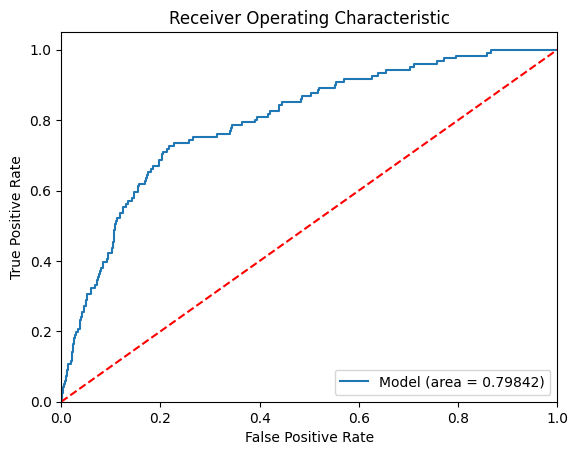

In [16]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter=1000)
evaluate_model(logReg, X_train, y_train, X_valid, y_valid)

Logistic Regression performs rather decently. Possible to train and tune it further

### Feature Selection Logistic Regression

In [23]:
# # Import SequentialFeatureSelector from Mlxtend
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# # Create a logistic regression classifier
# lr = LogisticRegression()

# # Create an SFS object
# sfs = SFS(estimator=lr,       # Use logistic regression as our classifier
#           k_features=(1, 10),  # Consider any feature combination between 1 and 4
#           forward=True,       # Set forward to True when we want to perform SFS
#           scoring='accuracy', # The metric to use to evaluate the classifier is accuracy 
#           cv=5)               # The number of cross-validations to perform is 5

# # Train SFS with our dataset
# sfs = sfs.fit(X_train, y_train)

# # Print the results
# print('Best accuracy score: %.2f' % sfs.k_score_)   # k_score_ shows the best score 
# print('Best subset (indices):', sfs.k_feature_idx_) # k_feature_idx_ shows the index of features 
#                                                     # that yield the best score
# print('Best subset (corresponding names):', sfs.k_feature_names_) # k_feature_names_ shows the feature names 
#                                                                   # that yield the best score

Best accuracy score: 0.72
Best subset (indices): (9, 17, 35, 62, 85, 103, 110, 113, 115, 123)
Best subset (corresponding names): ('flg_is_proposal', 'is_class_1_2', 'sumins_grp_caa6ff', 'prempaid_lh_947b15', 'lapse_ape_lh_507c37', 'f_ever_bought_gi', 'f_ever_bought_grp_1581d7', 'f_ever_bought_lh_839f8a', 'f_ever_bought_grp_caa6ff', 'f_ever_bought_lh_f852af')


Accuracy on validation set: 0.76817289
True Neg: 2268 	 False Pos: 665
False Neg: 43 	 True Pos: 78
Precision on validation set: 0.10497981
Recall on validation set: 0.64462810
F1-Score on validation set: 0.18055556


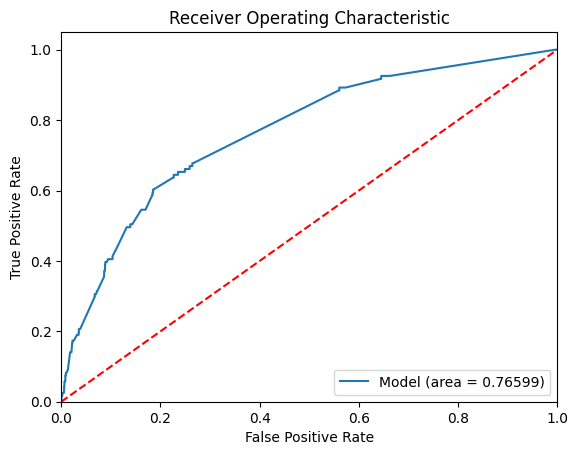

In [36]:
# X_new_train = sfs.transform(X_train)
# X_new_valid = sfs.transform(X_valid)

# logReg = LogisticRegression(max_iter=1000)
# evaluate_model(logReg, X_new_train, y_train, X_new_valid, y_valid)

### Lasso Ridge Regression

Accuracy on validation set: 0.77373936
True Neg: 2276 	 False Pos: 657
False Neg: 34 	 True Pos: 87
Precision on validation set: 0.11693548
Recall on validation set: 0.71900826
F1-Score on validation set: 0.20115607


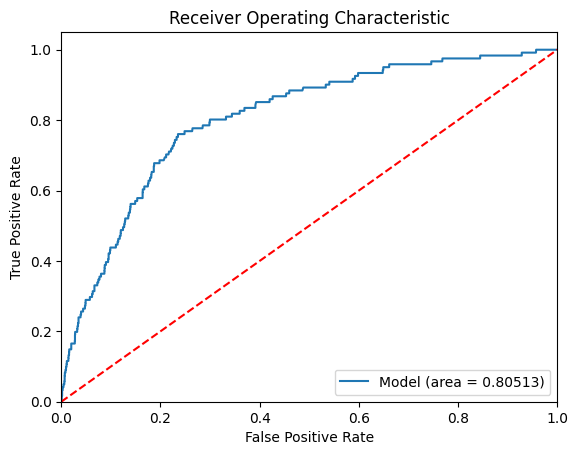

In [17]:
log = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
evaluate_model(log, X_train, y_train, X_valid, y_valid)

In [18]:
from itertools import chain
nonzero_coef = abs(log.coef_) > 0
nonzero_var = X_train.columns[list(chain.from_iterable(nonzero_coef))]
print(nonzero_var)
print(len(nonzero_var))

Index(['flg_male', 'flg_gi_claim', 'is_consent_to_mail', 'is_consent_to_call',
       'is_consent_to_sms', 'is_sg_pr', 'is_class_1_2', 'annual_income_est',
       'f_hold_839f8a', 'f_ever_bought_839f8a', 'f_ever_bought_e22a6a',
       'f_ever_bought_gi', 'f_ever_bought_grp_1581d7',
       'f_ever_bought_lh_e22a6a', 'f_ever_bought_lh_f852af', 'f_mindef_mha',
       'Chinese', 'Indian', 'P', 'age'],
      dtype='object')
20


Provides best result

## Decision Tree

Accuracy on validation set: 0.93222004
True Neg: 2831 	 False Pos: 102
False Neg: 105 	 True Pos: 16
Precision on validation set: 0.13559322
Recall on validation set: 0.13223140
F1-Score on validation set: 0.13389121


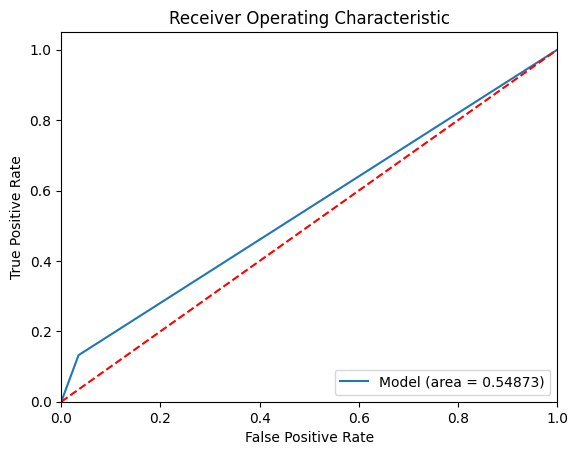

In [24]:
# from sklearn.tree import DecisionTreeClassifier
# tree = DecisionTreeClassifier()
# evaluate_model(tree, X_train, y_train, X_valid, y_valid)

Decision tree performs poorly. Do not need to further train it.

### Max-Depth Decision Tree

In [ ]:
# tree_trainaccuracy = np.zeros(shape=(tree.tree_.max_depth))
# tree_validaccuracy = np.zeros(shape=(tree.tree_.max_depth))
# for max_d in range(1,tree.tree_.max_depth+1):
#   tree2 = DecisionTreeClassifier(max_depth=max_d, random_state=42)
#   tree2.fit(X_train,y_train)
#   tree_trainaccuracy[max_d - 1]= tree2.score(X_train, y_train)
#   tree_validaccuracy[max_d - 1]= tree2.score(X_valid, y_valid)

# depths = range(1, tree.tree_.max_depth+1)

# # Plot and label the training and validation loss values
# plt.plot(depths, tree_trainaccuracy, label='Training Accuracy')
# plt.plot(depths, tree_validaccuracy, label='Validation Accuracy')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# # max_depth = sqrt(d)
# d = tree_validaccuracy.argmax(axis=0) + 1
# print(d)
# tree_depth = DecisionTreeClassifier(max_depth=d)
# evaluate_model(tree_depth, X_train, y_train, X_valid, y_valid)

### Feature Selection Decision Tree

In [ ]:
# from sklearn.feature_selection import SelectFromModel

# sel = SelectFromModel(DecisionTreeClassifier())
# sel.fit(X_train, y_train)
# selected_feat= X_train.columns[(sel.get_support())]
# print(selected_feat)

# newX_train = X_train[selected_feat]
# newX_valid = X_valid[selected_feat]

# dt_feat = DecisionTreeClassifier()
# evaluate_model(dt_feat, newX_train, y_train, newX_valid, y_valid)

Not much improvement with feature selection.

## Random Forest

Accuracy on validation set: 0.95841519
True Neg: 2922 	 False Pos: 11
False Neg: 116 	 True Pos: 5
Precision on validation set: 0.31250000
Recall on validation set: 0.04132231
F1-Score on validation set: 0.07299270


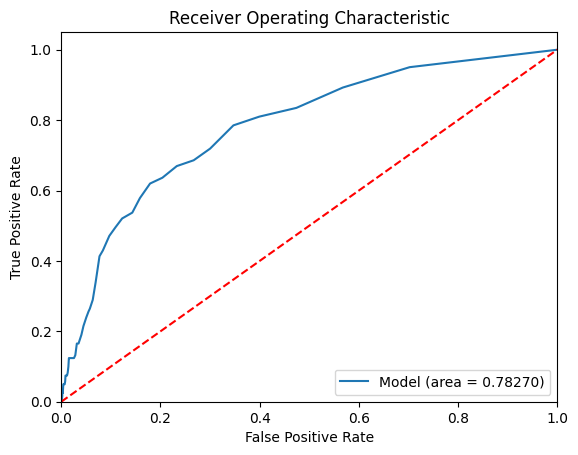

In [18]:
# from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier()
# evaluate_model(forest, X_train, y_train, X_valid, y_valid)

### Max-Depth Random Forest

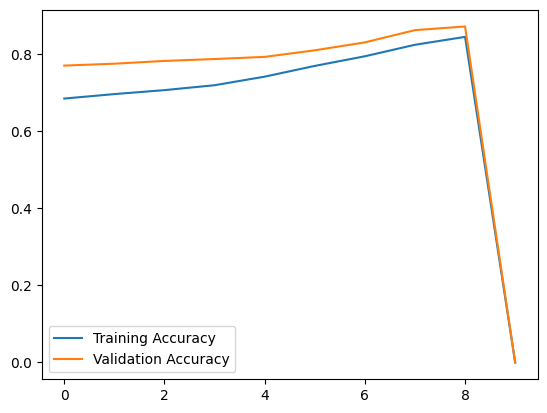

In [26]:
# forest_trainaccuracy = np.zeros(shape=(10))
# forest_validaccuracy = np.zeros(shape=(10))
# for max_d in range(1,10):
#   rf = RandomForestClassifier(max_depth=max_d, random_state=42)
#   rf.fit(X_train,y_train)
#   forest_trainaccuracy[max_d - 1]= rf.score(X_train, y_train)
#   forest_validaccuracy[max_d - 1]= rf.score(X_valid, y_valid)

# depths = range(0, 10)

# # Plot and label the training and validation loss values
# plt.plot(depths, forest_trainaccuracy, label='Training Accuracy')
# plt.plot(depths, forest_validaccuracy, label='Validation Accuracy')
# plt.legend(loc='best')
# plt.show()

9
Accuracy on validation set: 0.87557302
True Neg: 2611 	 False Pos: 322
False Neg: 58 	 True Pos: 63
Precision on validation set: 0.16363636
Recall on validation set: 0.52066116
F1-Score on validation set: 0.24901186


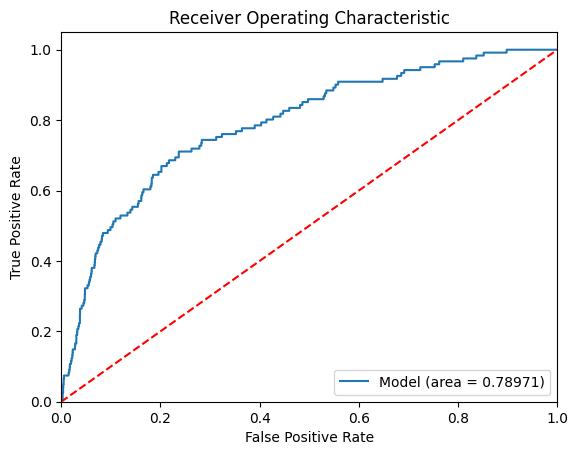

In [27]:
# # max_depth = sqrt(d)
# d = forest_validaccuracy.argmax(axis=0) + 1
# print(d)
# rf_depth = RandomForestClassifier(max_depth=d)
# evaluate_model(rf_depth, X_train, y_train, X_valid, y_valid)

### Random Forest Grid Search CV

In [28]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# param_grid = {
#     'bootstrap': [True],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 500]
# }

In [29]:
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_estimator_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   3.9s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   3.6s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   3.7s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   5.3s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total

Accuracy on validation set: 0.91388343
True Neg: 2755 	 False Pos: 178
False Neg: 85 	 True Pos: 36
Precision on validation set: 0.16822430
Recall on validation set: 0.29752066
F1-Score on validation set: 0.21492537


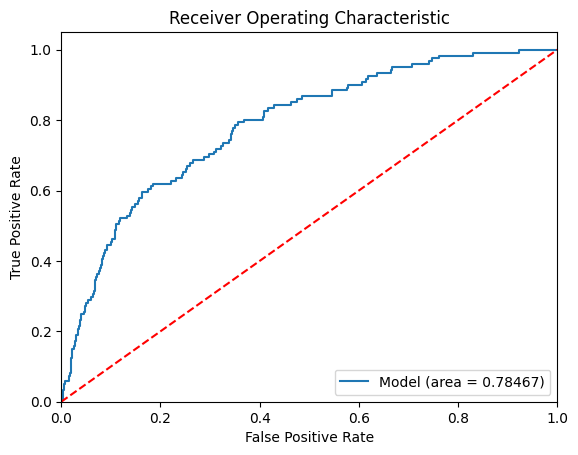

In [33]:
# rf_cvgrid = RandomForestClassifier(max_features=3, min_samples_leaf=3, min_samples_split=10,
#                        n_estimators=300)
# evaluate_model(rf_cvgrid, X_train, y_train, X_valid, y_valid)

### Random Forest Randomized Search CV

In [31]:
# from numpy.random import randint

# rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
#               'n_estimators':np.arange(10, 500, step=50),
#               'max_features':np.arange(1,7, step=1),
#               'criterion':['gini','entropy'],
#               'min_samples_leaf':np.arange(1,4,step=1),
#               'min_samples_split':np.arange(2, 10, step=2)
#           }

# random_search = RandomizedSearchCV(RandomForestClassifier(),
#                                    rs_space)

In [32]:
# random_search.fit(X_train, y_train)
# print(random_search.best_estimator_)

RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=110)


Accuracy on validation set: 0.95972495
True Neg: 2929 	 False Pos: 4
False Neg: 119 	 True Pos: 2
Precision on validation set: 0.33333333
Recall on validation set: 0.01652893
F1-Score on validation set: 0.03149606


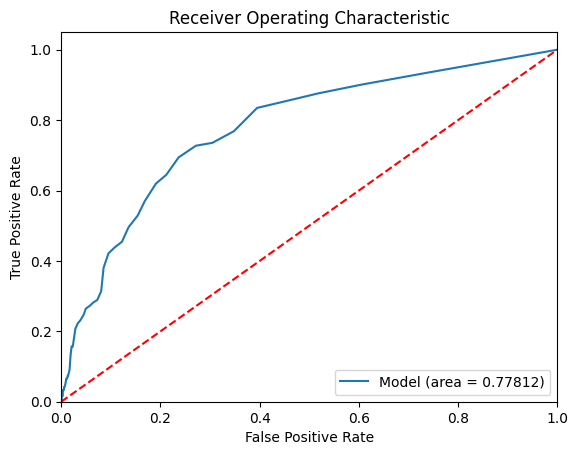

In [34]:
# rf_rscv = RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=110)
# evaluate_model(rf_rscv, X_train, y_train, X_valid, y_valid)

## KNN

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# knn_model = KNeighborsClassifier()
# evaluate_model(knn_model, X_train, y_train, X_valid, y_valid)

### KNN: k values

In [ ]:
# kn_trainaccuracy = np.zeros(10)
# kn_validaccuracy = np.zeros(10)
# for k in range(1,11):
#   kn = KNeighborsClassifier(n_neighbors=k)
#   kn.fit(X_train,y_train)
#   kn_trainaccuracy[k-1]= kn.score(X_train, y_train)
#   kn_validaccuracy[k-1]= kn.score(X_valid, y_valid)

# depths = range(1, 11)

# # Plot and label the training and validation loss values
# plt.plot(depths, kn_trainaccuracy, label='Training Accuracy')
# plt.plot(depths, kn_validaccuracy, label='Validation Accuracy')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# k = kn_validaccuracy.argmax(axis=0)
# print(k)
# knn_k = KNeighborsClassifier(n_neighbors=k)
# evaluate_model(knn_k, X_train, y_train, X_valid, y_valid)

### KNN: feature selection

In [ ]:
# from mlxtend.evaluate import PredefinedHoldoutSplit
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# knn = KNeighborsClassifier(n_neighbors=4)

# sfs1 = SFS(knn,
#            k_features=3,
#            forward=True,
#            floating=False,
#            verbose=2,
#            scoring='accuracy')

# sfs1 = sfs1.fit(X_train, y_train)


In [ ]:
# print('Selected features:', sfs1.k_feature_idx_)
# X_train_sfs = sfs1.transform(X_train)
# X_valid_sfs = sfs1.transform(X_valid)
# evaluate_model(knn, X_train_sfs, y_train, X_valid_sfs, y_valid)


## PCA/LDA/QDA/PLS

### PCA

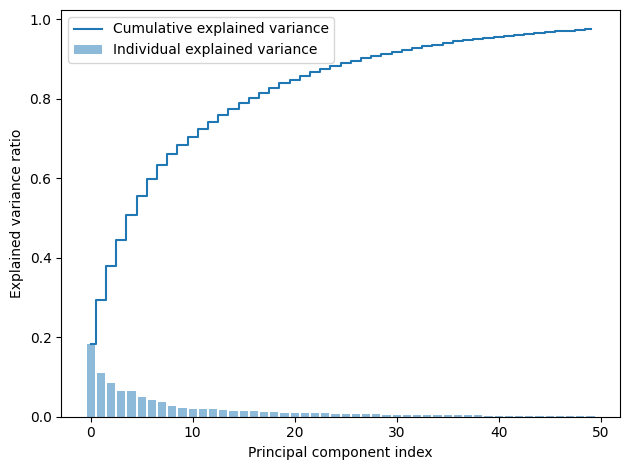

[0.18321817 0.11077614 0.08470769 0.0650344  0.06360566 0.04867289
 0.04194248 0.0362635  0.02634901 0.022875   0.02058798 0.01944635
 0.01828606 0.01728186 0.01496955 0.01460966 0.01398319 0.01278077
 0.01233789 0.01052924 0.00958553 0.009149   0.00895471 0.00850181
 0.00769569 0.00669702 0.00648691 0.00627224 0.00571785 0.00535652
 0.00520487 0.00484579 0.00456956 0.00441783 0.00430775 0.00406982
 0.00377822 0.00347848 0.00317159 0.00281865 0.00268147 0.00249885
 0.00243963 0.00228088 0.0020837  0.0020239  0.00192369 0.00181475
 0.00170715 0.00156673]


In [35]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=50)
# pca_X_train = pca.fit_transform(X_train)
# pca_X_test = pca.transform(X_valid)
# pca_explained_variance = pca.explained_variance_ratio_

# cum_sum_eigenvalues = np.cumsum(pca_explained_variance)
# #
# # Create the visualization plot
# #
# plt.bar(range(0,len(pca_explained_variance)), pca_explained_variance, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()

# print(pca_explained_variance)

PCA does not help to explain the variance well. Not a suitable dimension reducation method to be used.

In [ ]:
# model_pca = PCA(n_components=9)
# model_pca_X_train = model_pca.fit_transform(X_train)
# model_pca_X_valid = model_pca.transform(X_valid)

In [ ]:
# pca_logReg = LogisticRegression()
# evaluate_model(pca_logReg, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

In [ ]:
# pca_tree = RandomForestClassifier()
# evaluate_model(pca_tree, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Performs more poorly

In [ ]:
# pca_knn = KNeighborsClassifier()
# evaluate_model(pca_knn, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

### LDA

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# evaluate_model(lda, X_train, y_train, X_valid, y_valid)

### QDA

In [ ]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# qda = QuadraticDiscriminantAnalysis()
# evaluate_model(qda, X_train, y_train, X_valid, y_valid)

### PLS

In [ ]:
# from sklearn.cross_decomposition import PLSRegression
# pls_binary = PLSRegression(n_components=2)
# pls_binary.fit(X_train, y_train)

# pls_ypred_raw = pls_binary.predict(X_valid)[:,0]
# pls_ypred = (pls_binary.predict(X_valid)[:,0] > 0.5).astype('uint8')

# print('Precision of PLS-DA classifier on test set: {:.2f}'.format(accuracy_score(y_valid, pls_ypred)))
# print('Precision of PLS-DA classifier on test set: {:.2f}'.format(precision_score(y_valid, pls_ypred)))
# print('Recall of PLS-DA classifier on test set: {:.2f}'.format(recall_score(y_valid, pls_ypred)))

## Final Model

Accuracy on validation set: 0.81217520
True Neg: 2125 	 False Pos: 452
False Neg: 54 	 True Pos: 63
Precision on validation set: 0.12233010
Recall on validation set: 0.53846154
F1-Score on validation set: 0.19936709


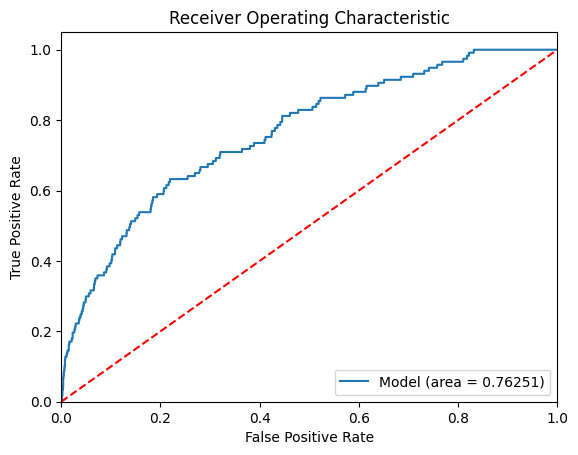

In [19]:
def train_model():
       nonzero_var = ['flg_male', 'flg_gi_claim', 'is_consent_to_mail', 'is_consent_to_call',
              'is_consent_to_sms', 'is_sg_pr', 'is_class_1_2', 'annual_income_est',
              'f_hold_839f8a', 'f_ever_bought_839f8a', 'f_ever_bought_e22a6a',
              'f_ever_bought_gi', 'f_ever_bought_grp_1581d7',
              'f_ever_bought_lh_e22a6a', 'f_ever_bought_lh_f852af', 'f_mindef_mha',
              'Chinese', 'Indian', 'P', 'age']
       final_model = LogisticRegression()

       X_train = pd.concat([X_train, X_valid, X_test])
       X_train = X_train[nonzero_var]
       y_train = pd.concat([y_train, y_valid, y_test])
       final_model.fit(X_train, y_train)
       return final_model

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    data = data_cleaning(hidden_data)
    data = remove_correlated(data)
    data = data[nonzero_var]
    
    final_model = train_model()
    result = final_model.predict(data)

    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!